### Libraries

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

from tensorflow.python.framework import ops

from __future__ import absolute_import
from __future__ import print_function
from os import listdir
from os.path import isfile, join

from keras.applications import imagenet_utils
from keras.utils import np_utils
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Functions

In [2]:
def unravel_argmax(argmax, shape):

    with tf.device('/gpu:0'):
        output_list = []
        output_list.append(argmax // (shape[2] * shape[3]))
        output_list.append(argmax % (shape[2] * shape[3]) // shape[3])
    return tf.stack(output_list)

def unpool_layer2x2_batch(x, argmax, offset = 0):
    '''
    Args:
        x: 4D tensor of shape [batch_size x height x width x channels]
        argmax: A Tensor of type Targmax. 4-D. The flattened indices of the max
        values chosen for each output.
    Return:
        4D output tensor of shape [batch_size x 2*height x 2*width x channels]
    '''

    with tf.device('/gpu:0'):
        x_shape = tf.shape(x)
        out_shape = [x_shape[0], x_shape[1]*2 + offset, x_shape[2]*2, x_shape[3]]

        batch_size = out_shape[0]
        height = out_shape[1]
        width = out_shape[2]
        channels = out_shape[3]

        argmax_shape = tf.to_int64([batch_size, height, width, channels])
        argmax = unravel_argmax(argmax, argmax_shape)

        t1 = tf.to_int64(tf.range(channels))
        t1 = tf.tile(t1, [batch_size*(width//2)*(height//2)])
        t1 = tf.reshape(t1, [-1, channels])
        t1 = tf.transpose(t1, perm=[1, 0])
        t1 = tf.reshape(t1, [channels, batch_size, height//2, width//2, 1])
        t1 = tf.transpose(t1, perm=[1, 0, 2, 3, 4])

        t2 = tf.to_int64(tf.range(batch_size))
        t2 = tf.tile(t2, [channels*(width//2)*(height//2)])
        t2 = tf.reshape(t2, [-1, batch_size])
        t2 = tf.transpose(t2, perm=[1, 0])
        t2 = tf.reshape(t2, [batch_size, channels, height//2, width//2, 1])
        
        t3 = tf.transpose(argmax, perm=[1, 4, 2, 3, 0])

        t = tf.concat([t2, t3, t1], 4)
        indices = tf.reshape(t, [(height//2)*(width//2)*channels*batch_size, 4])

        x1 = tf.transpose(x, perm=[0, 3, 1, 2])
        values = tf.reshape(x1, [-1])

        delta = tf.SparseTensor(indices, values, tf.to_int64(out_shape))
    return tf.sparse_tensor_to_dense(tf.sparse_reorder(delta))


In [3]:
def load_minibatch(full_path_unlabeled_files, full_path_labeled_files, k, minibatch_size):

    num_files = len(full_path_labeled_files)
    
    if (k + 1)*minibatch_size > num_files:
        num_files_to_load = num_files - k*minibatch_size
    else:
        num_files_to_load = minibatch_size
                             
    # Allocate array for unlabeled minibatch images
    minibatch_X = np.empty([num_files_to_load, 360, 480, 3], dtype = 'uint8')

    # Allocate array for labeled minibatch images
    minibatch_Y = np.empty([num_files_to_load, 360, 480], dtype = 'uint8')
    
    i = 0
    for n in range(k*minibatch_size, k*minibatch_size + num_files_to_load):
        minibatch_X[i] = cv2.imread(full_path_unlabeled_files[n], 1)
        minibatch_Y[i] = cv2.imread(full_path_labeled_files[n], 0)
        i = i + 1

    # Preprocess unlabeled images
    minibatch_X = minibatch_X.astype('float32')
    processed_minibatch_X = imagenet_utils.preprocess_input(minibatch_X)

    # Preprocess labeled images
    processed_minibatch_Y = np_utils.to_categorical(minibatch_Y.flatten(), 12)
    processed_minibatch_Y = processed_minibatch_Y.reshape((num_files_to_load, 360*480, 12))

    return processed_minibatch_X, processed_minibatch_Y

In [4]:
def list_files(unlabeled_path, labeled_path):
    
    labeled_files = [f for f in listdir(labeled_path) if isfile(join(labeled_path,f))]
    unlabeled_files = [f for f in listdir(unlabeled_path) if isfile(join(unlabeled_path,f))]

    num_files = len(labeled_files)
    
    assert (num_files == len(unlabeled_files)), "Different number of unlabeled and labeled files."
        
    # Shuffle
    permutation = list(np.random.permutation(num_files))
    
    full_path_labeled_files = []
    full_path_unlabeled_files = []
    
    for n in range(0, num_files):
        full_path_labeled_files.append(join(labeled_path, labeled_files[permutation[n]]))
        full_path_unlabeled_files.append(join(unlabeled_path, unlabeled_files[permutation[n]]))
        

    return full_path_unlabeled_files, full_path_labeled_files

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y): 
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_H0*n_W0, n_y])
    
    return X, Y

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [3, 3, 3, 64] Weights, numpy array of shape (f, f, n_C_prev, n_C)
                        W2 : [3, 3, 64, 128]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    W1 = tf.get_variable("W1", [3, 3, 3, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [3, 3, 64, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", [3, 3, 128, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W5 = tf.get_variable("W5", [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W6 = tf.get_variable("W6", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W7 = tf.get_variable("W7", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W8 = tf.get_variable("W8", [3, 3, 256, 512], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W9 = tf.get_variable("W9", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W10 = tf.get_variable("W10", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W11 = tf.get_variable("W11", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W12 = tf.get_variable("W12", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W13 = tf.get_variable("W13", [3, 3, 512, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W14 = tf.get_variable("W14", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W15 = tf.get_variable("W15", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W16 = tf.get_variable("W16", [3, 3, 256, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W17 = tf.get_variable("W17", [3, 3, 128, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W18 = tf.get_variable("W18", [3, 3, 128,  64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W19 = tf.get_variable("W19", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W20 = tf.get_variable("W20", [3, 3, 64, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4,
                  "W5": W5,
                  "W6": W6,
                  "W7": W7,
                  "W8": W8,
                  "W9": W9,
                  "W10": W10,
                  "W11": W11,
                  "W12": W12,
                  "W13": W13,
                  "W14": W14,
                  "W15": W15,
                  "W16": W16,
                  "W17": W17,
                  "W18": W18,
                  "W19": W19,
                  "W20": W20}
    
    return parameters

In [20]:
def forward_propagation(X, parameters):
    """
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last unit
    """
    
    with tf.device('/cpu:0'):
        # Retrieve the parameters from the dictionary "parameters" 
        W1 = parameters['W1']
        W2 = parameters['W2']
        W3 = parameters['W3']
        W4 = parameters['W4']
        W5 = parameters['W5']
        W6 = parameters['W6']
        W7 = parameters['W7']
        W8 = parameters['W8']
        W9 = parameters['W9']
        W10 = parameters['W10']
        W11 = parameters['W11']
        W12 = parameters['W12']
        W13 = parameters['W13']
        W14 = parameters['W14']
        W15 = parameters['W15']
        W16 = parameters['W16']
        W17 = parameters['W17']
        W18 = parameters['W18']
        W19 = parameters['W19']
        W20 = parameters['W20']

        # Encoder 1
        X = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)  

        X = tf.nn.conv2d(X, W2, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)
        shape_decoder_4 = tf.shape(X)
        X, ind1 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        # Encoder 2
        X = tf.nn.conv2d(X, W3, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)

        X = tf.nn.conv2d(X, W4, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)
        shape_decoder_3 = tf.shape(X)
        X, ind2 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        # Encoder 3
        X = tf.nn.conv2d(X, W5, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W6, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W7, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)
        shape_decoder_2 = tf.shape(X)
        X, ind3 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        # Encoder 4
        X = tf.nn.conv2d(X, W8, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W9, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)

        X = tf.nn.conv2d(X, W10, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)
        shape_decoder_1 = tf.shape(X)
        X, ind4 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        # Decoder 1
        X = unpool_layer2x2_batch(X, ind4, 1)
        X = tf.nn.conv2d(X, W11, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W12, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)

        X = tf.nn.conv2d(X, W13, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X)

        # Decoder 2
        X = unpool_layer2x2_batch(X, ind3)
        X = tf.nn.conv2d(X, W14, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W15, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W16, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        # Decoder 3
        X = unpool_layer2x2_batch(X, ind2)
        X = tf.nn.conv2d(X, W17, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W18, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        # Decoder 4
        X = unpool_layer2x2_batch(X, ind1)
        X = tf.nn.conv2d(X, W19, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.relu(X) 

        X = tf.nn.conv2d(X, W20, strides = [1,1,1,1], padding = 'SAME')
        X = tf.contrib.layers.batch_norm(X)
        X = tf.nn.softmax(X) 

        X = tf.reshape(X, [tf.shape(X)[0], 360*480, 12])

    return X

In [8]:
def compute_cost(Z3, Y):
    """  
    Arguments:
    Z3 -- output of forward propagation
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

### Model

In [9]:
def model(X_train_filelist, Y_train_filelist, learning_rate = 0.009,
              epochs = 100, minibatch_size = 64, print_cost = True, option = 'scratch'):

    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
    num_of_classes = 12
    (m, n_H0, n_W0, n_C0) = [len(X_train_filelist), 360, 480, 3]
    costs = []
    epoch_accuracy_list = []
    iteration_accuracy_list = []

    ##### Operations concerning minibatch size 

    all_minibatch_sizes = []

    num_minibatches = int(m / minibatch_size) 
    total_num_minibatches = int(math.ceil(m / minibatch_size))
    total_iters = total_num_minibatches * epochs

    for n in range(0, num_minibatches):
        all_minibatch_sizes.append(minibatch_size)

    if num_minibatches != total_num_minibatches:
        all_minibatch_sizes.append(m - (num_minibatches*minibatch_size))

    #####

    X, Y = create_placeholders(n_H0, n_W0, n_C0, num_of_classes)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)

    # Backpropagation: Define the tensorflow optimizer. SGD
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9).minimize(cost)

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, axis = 2)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, axis = 2))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Save model
    saver = tf.train.Saver()
    
    # Pretrained weights
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    W9 = parameters['W9']
    W10 = parameters['W10']
    
    pretrained_variables_dict = {"vgg_16/conv1/conv1_1/weights": W1,
                  "vgg_16/conv1/conv1_2/weights": W2,
                  "vgg_16/conv2/conv2_1/weights": W3,
                  "vgg_16/conv2/conv2_2/weights": W4,
                  "vgg_16/conv3/conv3_1/weights": W5,
                  "vgg_16/conv3/conv3_2/weights": W6,
                  "vgg_16/conv3/conv3_3/weights": W7,
                  "vgg_16/conv4/conv4_1/weights": W8,
                  "vgg_16/conv4/conv4_2/weights": W9,
                  "vgg_16/conv4/conv4_3/weights": W10}

    pretrained_saver = tf.train.Saver(pretrained_variables_dict)
    

        # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        if option == 'checkpoint':
            saver.restore(sess, "my_model.ckpt")
        elif option == 'pretrained':
            sess.run(init)
            pretrained_saver.restore(sess, "vgg_16.ckpt")
            Z3 = forward_propagation(X, parameters)
        else:
            sess.run(init)
            
        # Do the training loop
        for epoch in range(epochs):

            minibatch_cost = 0.
            print("Epoch %i started." % (epoch))

            for k in range(0,total_num_minibatches):

                # Load a minibatch
                minibatch_X, minibatch_Y = load_minibatch(X_train_filelist, Y_train_filelist, k, minibatch_size)

                # Run the session to execute the optimizer and the cost.
                with tf.device('/device:GPU:0'):
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                minibatch_cost += temp_cost / num_minibatches
                iteration_accuracy_list.append(accuracy.eval({X: minibatch_X, Y: minibatch_Y}))

                # Print training progress
                
                completed_iters = epoch * total_num_minibatches + (k + 1)
                percent_complete = (completed_iters * 100) / total_iters
                sys.stdout.write(str(percent_complete)+'%\r')
                sys.stdout.flush()


            epoch_accuracy = (sum([x*y for x,y in zip(iteration_accuracy_list, all_minibatch_sizes)]))/sum(all_minibatch_sizes)
            iteration_accuracy_list = []

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Epoch %i finished. Cost: %f   Accuracy: %f    Total progress: %f%%" % (epoch, minibatch_cost, epoch_accuracy, (epoch + 1)*100/epochs))

            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                epoch_accuracy_list.append(epoch_accuracy)

            # Save model
            saver.save(sess, './my_model.ckpt')

        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()


        # Calculate final accuracy
        final_accuracy = sum(epoch_accuracy_list)/epochs
        print("Final Accuracy:", final_accuracy)

    return X, Y, final_accuracy, parameters

### Testing

In [10]:
def load_data(labeled_path, unlabeled_path):

	# Find labeled files
	labeled_files = [f for f in listdir(labeled_path) if isfile(join(labeled_path,f))]
	# Find unlabeled files
	unlabeled_files = [f for f in listdir(unlabeled_path) if isfile(join(unlabeled_path,f))]

	# Allocate array for labeled images
	images_labeled = np.empty([len(labeled_files), 360, 480], dtype = 'uint8')

	# Allocate array for unlabeled images
	images_unlabeled = np.empty([len(unlabeled_files), 360, 480, 3], dtype = 'uint8')


	# Reading labeled images
	for n in range(0, len(labeled_files)):
	    images_labeled[n] = cv2.imread(join(labeled_path,labeled_files[n]), 0)

	# Reading unlabeled images
	for n in range(0, len(unlabeled_files)):
	    images_unlabeled[n] = cv2.imread(join(unlabeled_path,unlabeled_files[n]), 1)

	# Preprocess unlabeled images
	images_unlabeled = images_unlabeled.astype('float32')
	X = imagenet_utils.preprocess_input(images_unlabeled)

	# Preprocess labeled images
	n_labeled = len(labeled_files)
	Y = np_utils.to_categorical(images_labeled.flatten(), 12)
	Y = Y.reshape((n_labeled, images_labeled.size / n_labeled, 12))

	return X, Y

In [24]:
def testing(X_test, Y_test):
    ops.reset_default_graph()
    num_of_classes = 12
    (m, n_H0, n_W0, n_C0) = [X_test.shape[0], 360, 480, 3]
    parameters = initialize_parameters()
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    W9 = parameters['W9']
    W10 = parameters['W10']
    pretrained_saver = tf.train.Saver()
    with tf.Session() as sess:
            X, Y = create_placeholders(n_H0, n_W0, n_C0, num_of_classes)
            pretrained_saver.restore(sess, "my_model.ckpt")
            Z3 = forward_propagation(X, parameters)
            predict_op = tf.round(Z3)
            correct_prediction = tf.equal(predict_op, Y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
            meanIoU, confusionMatrix = tf.metrics.mean_iou(Y, correct_prediction, num_of_classes)
            
            init = tf.local_variables_initializer()
            sess.run(init)
            
            for i in range(1000):
                iou, _=sess.run([meanIoU, confusionMatrix])
            
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test}) # regular
    return test_accuracy, iou

### Main

In [12]:
# Paths
train_labeled_path = './CamVid/trainannot'
train_unlabeled_path = './CamVid/train'
test_labeled_path = './CamVid/testannot'
test_unlabeled_path = './CamVid/test'

# Define some parameters
input_shape = (360, 480, 3)
minibatch_size = 5
epochs = 1
learning_rate = 0.1

In [13]:
# Load dataset
print("Listing training dataset")
X_train_filelist, Y_train_filelist = list_files(train_unlabeled_path, train_labeled_path)
print("Listed")

Listing training dataset
Listed


In [25]:
# Train the model with pretrained weights from VGG-16
X, Y, accuracy, parameters = model(X_train_filelist, Y_train_filelist, learning_rate, epochs, minibatch_size, option = 'checkpoint')

INFO:tensorflow:Restoring parameters from my_model.ckpt


InvalidArgumentError: No OpKernel was registered to support Op 'MaxPoolWithArgmax' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: MaxPoolWithArgmax = MaxPoolWithArgmax[T=DT_FLOAT, Targmax=DT_INT64, ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/device:GPU:0"](Relu_1)]]

Caused by op 'MaxPoolWithArgmax', defined at:
  File "/Users/macbookpro13/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    self._closing = True
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    _state.contexts = cap_contexts[0]
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    _state.contexts = cap_contexts[0]
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-29295086a3dc>", line 2, in <module>
    X, Y, accuracy, parameters = model(X_train_filelist, Y_train_filelist, learning_rate, epochs, minibatch_size, option = 'checkpoint')
  File "<ipython-input-18-8031fd4b5ad3>", line 31, in model
    Z3 = forward_propagation(X, parameters)
  File "<ipython-input-24-73adc1105c5e>", line 44, in forward_propagation
    X, ind1 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1810, in max_pool_with_argmax
    Targmax=Targmax, name=name)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/macbookpro13/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'MaxPoolWithArgmax' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: MaxPoolWithArgmax = MaxPoolWithArgmax[T=DT_FLOAT, Targmax=DT_INT64, ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/device:GPU:0"](Relu_1)]]


Epoch 0 started.
Epoch 0 finished. Cost: 2.479584   Accuracy: 0.912702    Total progress: 33.000000%
Epoch 1 started.
Epoch 1 finished. Cost: 2.457000   Accuracy: 0.913255    Total progress: 66.000000%
Epoch 2 started.
Epoch 2 finished. Cost: 2.434981   Accuracy: 0.914527    Total progress: 100.000000%


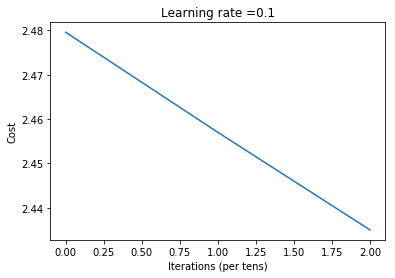

Final Accuracy: 0.913494911459


In [12]:
# Train the model with random initialized weights, dataset is formed by 20 images
X, Y, accuracy, parameters = model(X_train_filelist, Y_train_filelist, learning_rate, epochs, minibatch_size, option = 'scratch')

In [14]:
print("Loading testing dataset")
X_test, Y_test = load_data(test_labeled_path, test_unlabeled_path)
print("Loaded")

Loading testing dataset
Loaded


In [25]:
test_accuracy, iou = testing(X_test, Y_test)#accuracy.eval({X: X_test, Y: Y_test})
print(test_accuracy)
print(iou)

INFO:tensorflow:Restoring parameters from my_model.ckpt


InvalidArgumentError: Cannot assign a device for operation 'MaxPoolWithArgmax': Could not satisfy explicit device specification '/device:CPU:0' because no supported kernel for CPU devices is available.
	 [[Node: MaxPoolWithArgmax = MaxPoolWithArgmax[T=DT_FLOAT, Targmax=DT_INT64, ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/device:CPU:0"](Relu_1)]]

Caused by op u'MaxPoolWithArgmax', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/zaziza/virtualenv/project_space/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-7e435384885a>", line 1, in <module>
    test_accuracy, iou = testing(X_test, Y_test)#accuracy.eval({X: X_test, Y: Y_test})
  File "<ipython-input-24-3f48d4d4bf7e>", line 20, in testing
    Z3 = forward_propagation(X, parameters)
  File "<ipython-input-20-edf43b0168ba>", line 44, in forward_propagation
    X, ind1 = tf.nn.max_pool_with_argmax(X, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1898, in max_pool_with_argmax
    Targmax=Targmax, name=name)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/zaziza/virtualenv/project_space/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MaxPoolWithArgmax': Could not satisfy explicit device specification '/device:CPU:0' because no supported kernel for CPU devices is available.
	 [[Node: MaxPoolWithArgmax = MaxPoolWithArgmax[T=DT_FLOAT, Targmax=DT_INT64, ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/device:CPU:0"](Relu_1)]]
